# **Anomaly Detection for HDFS dataset**






# Import libraries


In [1]:
import numpy as np
import pandas as pd
import math, copy, time
import pickle
import os
import re

import signal
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

from tqdm import trange

import random
import re

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
import keras
np.random.seed(0)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# First enable GPU parallel execution

In [2]:
import tensorflow as tf
mirrored_strategy = tf.distribute.MirroredStrategy()

# Mount dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# special to google colab | put your 4 Datasets into this path
folder_path = '/content/drive/My Drive/LogSy'

Mounted at /content/drive


# Read in the datasets using preprocessor

In [4]:
"""
Standard tokenizer + do what the paper says
"""
"""
Do not run this script in Windows, it will not work due to use of signal

We also use authors preprocessor to evaluate our model just in case we made something wrong here
"""

class TimeoutException(Exception):  # Custom exception class
    pass


def timeout_handler(signum, frame):  # Custom signal handler
    raise TimeoutException


# Change the behavior of SIGALRM
signal.signal(signal.SIGALRM, timeout_handler)


class DataTokenizer:
    def __init__(self):
        self.word2index = {'[PAD]': 0, '[CLS]': 1, '[MASK]': 2}
        self.num_words = 3
        self.stop_words = set(stopwords.words('english'))

    def tokenize(self, message):
        # paper section IV: Tokenization processing
        message = message.lower()
        message = re.sub(r'/.*:', '', message, flags=re.MULTILINE)  # filter for endpoints
        message = re.sub(r'/.*', '', message, flags=re.MULTILINE)
        message = word_tokenize(message)  # remove non words
        message = (word for word in message if word.isalpha())  # generator  # remove numerical
        message = [word for word in message if word not in self.stop_words]  # remove nltk common stopwords
        message = ['[CLS]'] + message  # add embedding token
        for word_idx, word in enumerate(message):  # convert to value
            if word not in self.word2index:
                self.word2index[word] = self.num_words
                self.num_words += 1
            message[word_idx] = self.word2index[word]
        return message
tokenizer = DataTokenizer()

from tqdm.auto import tqdm
class DataImporter:
    """
    loads data set from the raw dataset
    """

    def __init__(self, log_template, dataset_folder_path, dataset_name, dataset_step=1,
                 dataset_limit=100000, dataset_type='main', normal_indicator: str = '-', aux_count=50000,
                 chunk: bool = True):
        self.log_template = log_template  # a template containing <Token{n}> and <Message>
        self.log_dataframe = None
        self.dataset_folder_path: str = dataset_folder_path  # path to the dataset folder
        self.dataset_name: str = dataset_name  # full name of raw dataset
        self.step: int = dataset_step  # step taken to sample auxiliary dataset
        self.log_template_regex: re = re.compile(r'')
        self.log_template_headers: list[str] = []
        self.limit: int = dataset_limit  # used for faster experiment only
        self.dataset_type: str = dataset_type
        self.normal_indicator: str = normal_indicator  # a sign indicating the log line is anomaly
        self.aux_count: int = aux_count
        self.chunk: bool = chunk

    def log_loader(self):
        """
        read from IO stream and only take the actual log message based on template
        :return:
        """
        log_messages = []
        true_labels = []
        with open(os.path.join(self.dataset_folder_path, self.dataset_name), 'r', encoding="latin-1") as ds:
            for line_no, line in enumerate(tqdm(ds, miniters=1)):
                if line_no != 1 and line_no % 20000000 == 1:  # 15 file chunks
                    with open(f'dataset/tbird/{self.dataset_name}_chunked_msg_line{line_no}', 'wb') as message_file:
                        # print(log_messages)
                        # log_messages_array = np.asanyarray(log_messages).reshape(-1, 1)
                        print(len(log_messages))
                        l = len(log_messages)
                        tokenized = [tokenizer.tokenize(log_message) for log_message in
                                     tqdm(log_messages, position=0, leave=True, total=l)]
                        tokenized_np = np.asanyarray(tokenized)
                        del tokenized
                        pickle.dump(tokenized_np, message_file)
                        log_messages = []  # reset
                # Start the timer. Once 10 seconds are over, a SIGALRM signal is sent.
                try:
                    try:
                        signal.alarm(30)

                        match = self.log_template_regex.search(line.strip())

                        if not match:
                            continue
                        label_decider = lambda x: 0 if x == self.normal_indicator else 1
                        true_labels.append(label_decider(match.group('Token0')))
                        # message = tokenizer.tokenize(match.group('Message'))
                        # log_messages.append(message)
                        log_messages.append(match.group('Message'))
                        # print('message after tokenize ', message, log_messages)
                        # print(self.log_template_headers)
                    except Exception as e:  # noqa
                        print(e)
                        # print(e) # will skip those without normal indications('-' OR 'warn')
                        pass
                except TimeoutException:
                    print("Regex hang detected, skipping")
                    continue  # catastrophic backtracking
                else:
                    signal.alarm(0)
                if line_no == self.limit:
                    break
        return log_messages, np.array(true_labels)  # remaining log_messages and all of labels

    def load(self):
        self.log_template_matcher()

        self.log_dataframe = self.log_loader()


    def log_template_matcher(self):
        headers = []
        splitters = re.split(r'(<[^<>]+>)', self.log_template)
        regex = ''
        for k in range(len(splitters)):
            if k % 2 == 0:
                splitter = re.sub(' +', '\\\s+', splitters[k])
                regex += splitter
            else:
                header = splitters[k].strip('<').strip('>')
                regex += '(?P<%s>.+?)' % header
                headers.append(header)
        print(regex)
        regex = re.compile('^' + regex + '$')

        self.log_template_headers, self.log_template_regex = headers, regex

In [14]:
# original authors' data processor
class LogReader:
    def __init__(self, log_format, log_name, indir='./', outdir='./result/', rex=[], every_n=10, max_lines=2000000):
        self.path = indir
        self.logName = log_name
        self.savePath = outdir
        self.df_log = None
        self.log_format = log_format
        self.rex = rex
        self.every_n = every_n
        self.max_lines = max_lines

    def log_to_dataframe(self, log_file, regex, headers, logformat):
        """ Function to transform log file to dataframe """
        log_messages = []
        linecount = 0

        if self.max_lines:
            with open(log_file, 'r', encoding="latin-1") as fin:
                for i, line in enumerate(fin):
                    if i % self.every_n == 0:
                        try:
                            match = regex.search(line.strip())
                            message = [match.group(header) for header in headers]
                            log_messages.append(message)
                            linecount += 1
                        except Exception as e:
                            pass
                    if i == self.max_lines:
                        break
        else:
            with open(log_file, 'r', encoding="latin-1") as fin:
                for i, line in enumerate(fin):
                    if i % self.every_n == 0:
                        try:
                            match = regex.search(line.strip())
                            message = [match.group(header) for header in headers]
                            log_messages.append(message)
                            linecount += 1
                        except Exception as e:
                            pass

        logdf = pd.DataFrame(log_messages, columns=headers)
        if 'LineId' not in logdf.columns:
          logdf.insert(0, 'LineId', None)
          logdf['LineId'] = [i + 1 for i in range(linecount)]

        return logdf

    def generate_logformat_regex(self, logformat):
        """ Function to generate regular expression to split log messages """
        headers = []
        splitters = re.split(r'(<[^<>]+>)', logformat)
        regex = ''
        for k in range(len(splitters)):
            if k % 2 == 0:
                splitter = re.sub(' +', '\\\s+', splitters[k])
                regex += splitter
            else:
                header = splitters[k].strip('<').strip('>')
                regex += '(?P<%s>.*?)' % header
                headers.append(header)
        regex = re.compile('^' + regex + '$')
        return headers, regex

    def load_data(self):
        headers, regex = self.generate_logformat_regex(self.log_format)
        self.df_log = self.log_to_dataframe(os.path.join(self.path, self.logName), regex, headers, self.log_format)

# LogTokenizer class for tokenizing log content
class LogTokenizer:
    def __init__(self):
        self.word2index = {'[PAD]': 0, '[CLS]': 1, '[MASK]': 2}
        self.index2word = {0: '[PAD]', 1: '[CLS]', 2: '[MASK]'}
        self.n_words = 3  # Count special tokens
        self.stop_words = set(stopwords.words('english'))
        self.regextokenizer = nltk.RegexpTokenizer('\w+|.|')

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

    def tokenize(self, sent):
        sent = re.sub(r'\/.*:', '', sent, flags=re.MULTILINE)
        sent = re.sub(r'\/.*', '', sent, flags=re.MULTILINE)
        sent = self.regextokenizer.tokenize(sent)
        sent = [w.lower() for w in sent]
        sent = [word for word in sent if word.isalpha()]
        sent = [w for w in sent if not w in self.stop_words]
        sent = ['[CLS]'] + sent
        for w in range(len(sent)):
            self.addWord(sent[w])
            sent[w] = self.word2index[sent[w]]
        return sent

# Function to load general datasets
def get_data(log_file, input_dir, output_dir, log_format, regex=[], every_n=10, aux=0, max_lines=5000000):
    reader = LogReader(log_format, log_file, indir=input_dir, outdir=output_dir, rex=regex, every_n=every_n, max_lines=max_lines)
    reader.load_data()
    log_payload, true_labels = reader.df_log.Content, np.where(reader.df_log.t.values == '-', 0, 1)
    del reader
    if aux != 0:
        df_anomalies = log_payload.iloc[true_labels.flatten() == 1].sample(n=aux).values
        df_normal = log_payload.iloc[true_labels.flatten() == 0].sample(n=aux).values
        return df_normal, df_anomalies
    else:
        return log_payload, true_labels

# Function to load special datasets
def get_data_special(log_file, input_dir, output_dir, log_format, regex=[], every_n=10, aux=0, max_lines=2000000):
    reader = LogReader(log_format, log_file, indir=input_dir, outdir=output_dir, rex=regex, every_n=every_n, max_lines=max_lines)
    reader.load_data()
    log_payload, true_labels = reader.df_log.Content, np.where(reader.df_log.t.values != 'FATAL', 0, 1)
    del reader

    return log_payload, true_labels

# New function to load HDFS dataset
def get_data_hdfs(log_file, input_dir, output_dir, log_format, regex=[], every_n=1, max_lines=5000000):
    reader = LogReader(log_format, log_file, indir=input_dir, outdir=output_dir, rex=regex, every_n=every_n, max_lines=max_lines)
    reader.load_data()

    # Clean the Label column
    reader.df_log['Label'] = reader.df_log['Label'].apply(lambda x: x.split(',')[-1])
    print(reader.df_log['Label'].value_counts())  # Debugging: Verify cleaned labels

    # Retain rows with valid labels only
    valid_labels = ['Normal', 'Anomaly']
    reader.df_log = reader.df_log[reader.df_log['Label'].isin(valid_labels)]

    # Map labels to binary values
    log_payload, true_labels = reader.df_log.Content, np.where(reader.df_log.Label == 'Normal', 0, 1)

    del reader
    return log_payload, true_labels





# First 3 aux datasets

In [6]:
log_file = 'spirit_small'
input_dir  = folder_path
output_dir = '.'
log_format = '<t> <Timestamp> <Date> <User> <Month> <Day> <Time> <Location> <Content>'  #spirit2

aux_normal, aux_anomalies = get_data(log_file, input_dir, output_dir, log_format, every_n=1, aux=200000, max_lines=False) # use 200000 when its tbird2 small (5m)

In [7]:
log_file = 'tbird2_small' # small meaning the dataset using only first 5m, note model doesn't converge well when sampling 5m instead of first 5m even if using original authors code
input_dir  = folder_path
log_format = '<t> <Timestamp> <Date> <User> <Month> <Day> <Time> <Location> <Component>(\[<PID>\])?: <Content>'  #thunderbird
output_dir = '.'
every_n = 1
aux_size = 200000
aux_normal1, aux_anomalies1= get_data(log_file, input_dir, output_dir, log_format, every_n=1, aux=200000, max_lines=False)


In [8]:
log_file = 'Intrepid_RAS_0901_0908_scrubbed' # this one cannot be used as target, its too obvious
input_dir  = folder_path
output_dir = '.'
log_format = '<f> <a>          <c>       <d>                  <e>    <t> <Content>'  #BGP
aux_anomalies_t, tl = get_data_special(log_file, input_dir, output_dir, log_format, every_n=1, aux=False, max_lines=False)
aux_normal2, aux_anomalies2  = aux_anomalies_t[tl==1], aux_anomalies_t[tl==0] # reverse this [TODO]


## Concat the auxiliary dataasets to one single piece, then sample if it was more than a threshold


In [9]:
# concatenate
aux_anomalies = np.append(aux_anomalies, aux_anomalies1)
aux_anomalies_full = np.append(aux_anomalies, aux_anomalies2)

In [10]:
# sample
if aux_anomalies.shape[0] > 500000:
  aux_anomalies = np.random.choice(aux_anomalies_full, size=500000, replace=False)  # changing size doesn't seem to change results
  print(f"Selected {aux_anomalies.shape} samples out of {len(aux_anomalies_full)} aux samples")

# Then target dataset - switch with aux if you need to evaluate different target

In [15]:
# Specify the HDFS log file details
log_file = 'labeled_HDFS.csv'  # HDFS log file name or path
input_dir = folder_path  # Directory containing the HDFS log file
output_dir = '.'  # Directory for saving intermediate parsing results
log_format = '<Date>,<Time>,<Pid>,<Level>,<Component>,<Content>,<BlockId>,<Label>'

# Load the HDFS dataset using the custom function
log_payload, true_labels = get_data_hdfs(log_file=log_file, input_dir=input_dir, output_dir=output_dir, log_format=log_format, every_n=1, max_lines=5000000)

# Print some basic details about the dataset
print(f"Total logs: {len(log_payload)}")
print(f"Anomalous logs: {np.sum(true_labels)}")
print(f"Normal logs: {len(true_labels) - np.sum(true_labels)}")


Label
Normal     1014970
Anomaly      33605
Name: count, dtype: int64
Total logs: 1048575
Anomalous logs: 33605
Normal logs: 1014970


In [ ]:
### Never shuffle the data here, or there will be info leak

In [16]:
df_size = len(log_payload)
df_size

1048575

In [17]:
true_labels = true_labels.reshape(-1,1)

In [18]:
#append the anomalies to the full data
log_payload = np.append(log_payload.values.reshape(-1,1), aux_anomalies.reshape(-1,1), axis=0)
true_labels = np.append(true_labels, np.ones(len(aux_anomalies)).reshape(-1,1), axis=0).flatten()
print(f'log shape {log_payload.shape}, log labels shape {true_labels.shape}')

log shape (1448575, 1), log labels shape (1448575,)


# Tokenize!

In [19]:

tokenizer = LogTokenizer()
df_len = int(log_payload.shape[0]) # the num of logs
data_tokenized = []
for i in trange(df_len):
    tokenized = tokenizer.tokenize(log_payload[i][0])
    data_tokenized.append(tokenized)

100%|██████████| 1448575/1448575 [00:18<00:00, 80180.54it/s]


In [20]:
# pickle to file
with open('tokenized','wb') as tokenized_file:
  pickle.dump(data_tokenized, tokenized_file)

In [21]:
# save it for multiple executions with different split rate
with open('tokenized','rb') as token:
  data_tokenized = pickle.load(token)

In [22]:
data_token_indexed = np.asanyarray(data_tokenized, dtype=object)

#Standard transformer encoder with multi-head *attention*

In [23]:
class TransformerEncoder(layers.Layer): # standard tensformer encoder
    def __init__(self, embed_dim, num_heads, dense_dim, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,dropout=0.1
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True
        self.dropout1 = layers.Dropout(0.05)
        self.dropout2 = layers.Dropout(0.05)

    def call(self, inputs, training, mask=None):
        padding_mask = None # Initialize padding_mask to None
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        attention_output = self.dropout1(attention_output, training=training)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        proj_output = self.dropout2(proj_output, training=training)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)



# IMPORTANT: CHANGE TRAIN TEST SPLIT RATIO HERE

In [24]:
ratio = 0.6 # change from 0.1 0.2 0.4 0.6 0.8 its not always 0.8 performas better than 0.1

In [25]:
train_size = round(df_size * ratio)
print(df_size, train_size)
print(f"train size proportional to total logs - {train_size/df_size}")

1048575 629145
train size proportional to total logs - 0.6


In [26]:
from collections import Counter
# perform train test split

# only take normal logs in target within ratio range
data_token_indexed_train = np.append(data_token_indexed[:train_size][true_labels[:train_size]==0], data_token_indexed[df_size:],axis=0)

# put remaining to test
data_token_indexed_test = data_token_indexed[train_size:df_size]


# labels using same split
train_ground_labels = np.append(true_labels[:train_size][true_labels[:train_size]==0].flatten(), true_labels[df_size:].flatten(),axis=0)
print(f"train ground labels 0 1 counter {Counter(train_ground_labels)}")

test_ground_labels = true_labels[train_size:df_size]
print(f"test ground labels 0 1 counter {Counter(test_ground_labels)}")

print(data_token_indexed_test.shape, data_token_indexed_train.shape, train_ground_labels.shape, test_ground_labels.shape)

train ground labels 0 1 counter Counter({0.0: 606758, 1.0: 400000})
test ground labels 0 1 counter Counter({0.0: 408212, 1.0: 11218})
(419430,) (1006758,) (1006758,) (419430,)


In [27]:
# verify unique log counts consistent with paper count
unique_counter = np.intersect1d(np.unique(data_token_indexed_test), np.unique(data_token_indexed_train), assume_unique=True)
print(f"Unique log message count - {np.unique(data_token_indexed_test).shape[0] - unique_counter.shape[0]}")

Unique log message count - 14


In [28]:
!pip install Keras-Preprocessing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [29]:

# assign set names
x_train = data_token_indexed_train
y_train =  train_ground_labels
x_test = data_token_indexed_test
y_test = test_ground_labels

# Add padding to sequences to maxlen 50 according to paper
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=50, truncating="post", padding="post")
x_test = pad_sequences(x_test, maxlen=50, truncating="post", padding="post")
print(x_train.shape, x_test.shape)
print(x_train[0])
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

## padding masks
x_train_masks = tf.equal(x_train, 0)
x_test_masks = tf.equal(x_test, 0)
print(x_train_masks,x_test_masks)

(1006758, 50) (419430, 50)
[1 3 4 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
(1006758, 50) (1006758,) (419430, 50) (419430,)
tf.Tensor(
[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]], shape=(1006758, 50), dtype=bool) tf.Tensor(
[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]], shape=(419430, 50), dtype=bool)


# Metrics and model building

In [43]:
a = tf.metrics.BinaryAccuracy()
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def accuracy_m(y_true, y_pred):
    a.update_state(y_true,y_pred)
    return a.result()

def custom_loss_function(y_true, y_pred):
    print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
    loss = K.mean((1 - y_true) * K.sqrt(y_pred) - y_true * K.log(1 - K.exp(-K.sqrt(y_pred))))
    return loss

def create_model():
    embed_dim = 16  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 16  # Hidden layer size in feed forward network inside transformer

    vocab_size = tokenizer.n_words  # Only consider the top 20k words
    maxlen = 50
    #"""---------Modified code blcok-------------------
    class PositionalEmbedding(layers.Layer):
        def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
            super(PositionalEmbedding, self).__init__(**kwargs)
            self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
            self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)

        def call(self, inputs):
            positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
            positions = self.position_embeddings(positions)
            x = self.token_embeddings(inputs)
            return x + positions

    class SquaredSumLayer(tf.keras.layers.Layer):
        def call(self, x):
            return tf.reduce_sum(tf.square(x), axis=1)
#-----------------------------------------------"""

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = PositionalEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerEncoder(embed_dim, num_heads, ff_dim)
    transformer_block2 = TransformerEncoder(embed_dim, num_heads, ff_dim)

    x = transformer_block(x, training=True)
    x = transformer_block2(x, training=True)

    #outputs = tf.gather(x, 0, axis=1)  # Take the CLS token as embedding
    outputs = tf.keras.layers.Lambda(lambda x: tf.gather(x, 0, axis=1))(x)
    outputs = tf.keras.layers.Lambda(lambda x: K.sum(K.square(x), axis=1))(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, # 0.0001,
    decay_steps=10000,
    decay_rate=1-0.001)
# Compile the model within the distributed strategy scope
with mirrored_strategy.scope():
    model = create_model()

    model_opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)

    model.compile(
        optimizer=model_opt,
        loss=custom_loss_function,
        metrics=['binary_accuracy', recall_m, precision_m],
        loss_weights=[1.0]
    )

    print(model.summary())



Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_embedding_4               │ (None, 50, 16)              │           4,640 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_8                │ (None, 50, 16)              │           2,768 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_9                │ (None, 50, 16)              │           2,768 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_9 (Lambda)                    │ (None)                      │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,176 (39.75 KB)

 Trainable params: 10,176 (39.75 KB)

 Non-trainable params: 0 (0.00 B)

None


# Evaluation steps

In [51]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# We have no idea how original author got the thresholds, we use average of auc score
def evaluation_threshold(threshold, y_test, distances):

  tr = [threshold]

  for t in tr:
    res=[]
    for d in distances:
      if d > t:
        res.append(1)
      else:
        res.append(0)

    f1score = f1_score(y_test.astype(np.int32), res)
    recall = recall_score(y_test.astype(np.int32), res)
    precision = precision_score(y_test.astype(np.int32), res)
    accuracy = accuracy_score(y_test.astype(np.int32), res)
    print('threshold value: ', t)
    print('f1: ', f1score)
    print('recall: ',  recall)
    print('precision: ', precision)
    print('Accuracy: ', accuracy)
    print('##################################')
    return t, f1score, recall, precision, accuracy

max_accuracy = 0
max_recall = 0
max_precision = 0
max_f1score = 0

max_accuracy_test = 0
max_recall_test = 0
max_precision_test = 0
max_f1score_test = 0

with mirrored_strategy.scope():
    for i in range(20):
        print(f"Currently Running Epoch - {i+1}")
        model.fit(x_train, y_train, batch_size=2048, epochs=1)

        # Evaluate performance
        test_distances = model.predict(x_test, batch_size=2048)
        train_distances = model.predict(x_train, batch_size=2048)

        test_auc = roc_auc_score(y_test.astype(np.int32), test_distances)
        train_auc = roc_auc_score(y_train.astype(np.int32), train_distances)

        fpr_test, tpr_test, thresholds_test = roc_curve(y_test.astype(np.int32), test_distances, pos_label=1)
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train.astype(np.int32), train_distances, pos_label=1)

        print(f"Train AUC: {train_auc}, Test AUC: {test_auc}")

        if train_auc == 1: # prevent calculation go wrong, not impacting results
          train_auc = 0.99
        if test_auc == 1:
          test_auc = 0.99

        print('Using trainset to find threshold:') # this should be legit
        t, f1score, recall, precision, accuracy = evaluation_threshold(np.average(thresholds_train[tpr_train>train_auc]), y_test, test_distances)
        print('Using testset to find threshold:') # this is what the authors used, which leaks info
        t_test, f1score_test, recall_test, precision_test, accuracy_test = evaluation_threshold(np.average(thresholds_test[tpr_test>test_auc]), y_test, test_distances)

        if max_accuracy <= accuracy:
          max_accuracy = accuracy
          max_recall = recall
          max_precision = precision
          max_f1score = f1score

        if max_accuracy_test <= accuracy_test:
          max_accuracy_test = accuracy_test
          max_recall_test = recall
          max_precision_test = precision_test
          max_f1score_test = f1score_test


Currently Running Epoch - 1
492/492 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - binary_accuracy: 0.9997 - loss: 0.0233 - precision_m: 1.0000 - recall_m: 0.9993
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
Train AUC: 1.0, Test AUC: 0.5176865166240139
Using trainset to find threshold:
threshold value:  11.76415
f1:  0.05530033804281876
recall:  0.02843644143341059
precision:  1.0
Accuracy:  0.9740147342822402
##################################
Using testset to find threshold:
threshold value:  5.677524e-05
f1:  0.05074883542317132
recall:  0.5418969513282225
precision:  0.026620948176953325
Accuracy:  0.4578022554419093
##################################
Currently Running Epoch - 2
492/492 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - binary_accuracy: 0.9997 - loss: 0.0155 - precision_m: 1.0000 - recall_m: 0.9993
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
Train AUC: 1.0, Test AUC: 0.5250599222083655
Using trainset to find th

In [52]:
print("*******\nauthor's best:")
print(max_accuracy_test, max_precision_test, max_recall_test, max_f1score_test)

*******
author's best:
0.4578022554419093 0.026620948176953325 0.02843644143341059 0.05074883542317132


In [53]:
print("*******\ntrain's best:")
print(max_accuracy, max_precision, max_recall, max_f1score)

*******
train's best:
0.9740266552225639 1.0 0.02888215368158317 0.05614278287991682


# Visualization

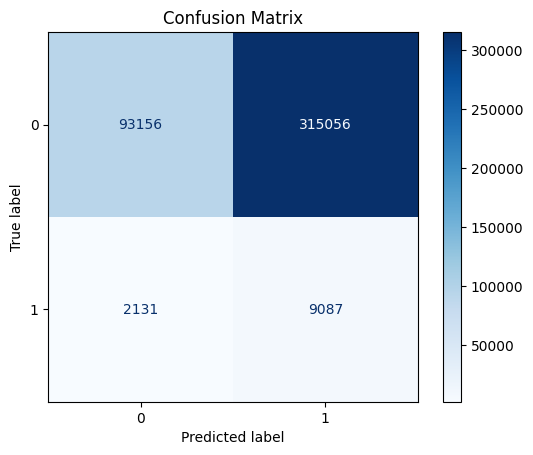

In [54]:
#Confusion Matrix Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

# Example Usage
threshold = np.average(thresholds_test[tpr_test > test_auc])  # Replace with a valid condition
predicted_classes = [1 if dist > threshold else 0 for dist in test_distances]  # Adjust threshold as needed
plot_confusion_matrix(y_test, predicted_classes)


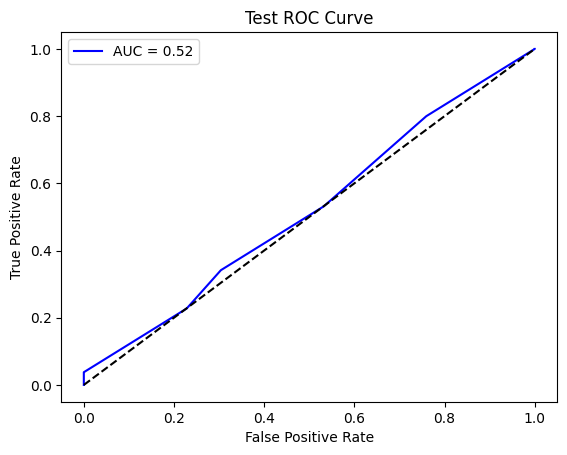

In [55]:
#Plotting ROC Curve
def plot_roc_curve(fpr, tpr, auc_score, title="ROC Curve"):
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

# Example Usage
plot_roc_curve(fpr_test, tpr_test, test_auc, title="Test ROC Curve")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


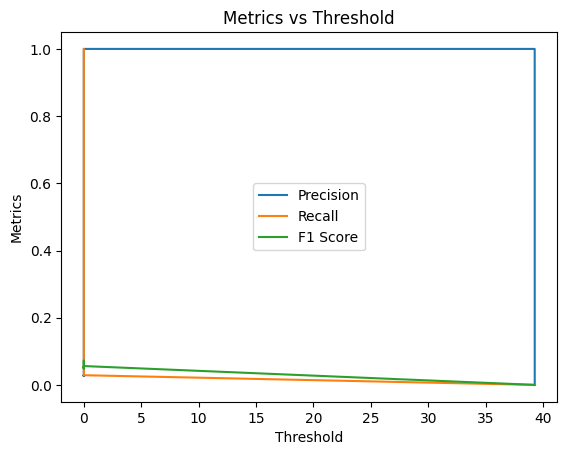

In [56]:
#Metrics vs Threshold Plot
def plot_metrics_vs_threshold(thresholds, precisions, recalls, f1s):
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.xlabel('Threshold')
    plt.ylabel('Metrics')
    plt.title('Metrics vs Threshold')
    plt.legend()
    plt.show()

# Example Usage
thresholds = thresholds_test
precisions = [precision_score(y_test, [1 if dist > t else 0 for dist in test_distances]) for t in thresholds]
recalls = [recall_score(y_test, [1 if dist > t else 0 for dist in test_distances]) for t in thresholds]
f1s = [f1_score(y_test, [1 if dist > t else 0 for dist in test_distances]) for t in thresholds]
plot_metrics_vs_threshold(thresholds, precisions, recalls, f1s)
